In [129]:
from typing import Tuple, List
import numpy as np
import pandas as pd
import json
import re
import random
import epitran  # phonetics
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, BertTokenizer
import matplotlib.pyplot as plt

# 1. create sentences with common typos

In [ ]:


class StringManipulator:
    @staticmethod
    def manipulate_words(string: str, func, min_p: float = 0.1, max_p: float = 0.5) -> str:
        """
        manipulate each words with a probability between min_p and max_p
        """
        words = string.split(" ")
        # determine which words to manipulate
        p = random.uniform(min_p, max_p)
        pos_manipulate = [i for i in range(len(words)) if random.random() <= p]
        # manipulate
        string_final = ""
        for i, word in enumerate(words):
            if word != "":
                if i in pos_manipulate:
                    string_final += " " + random.choice(func(word))
                else:
                    string_final += " " + word
        return string_final[1:]


class Typo(StringManipulator):
    """
    uses german keyboard layout by default (only letters)
    """
    def __init__(self, alternative_layout: dict = None) -> None:
        super().__init__()
        self.epi = epitran.Epitran('deu-Latn')
        if alternative_layout is not None:
            layout = alternative_layout
        else:
            layout = {
            'q': (0, 0), 'w': (0, 1), 'e': (0, 2), 'r': (0, 3), 't': (0, 4), 'z': (0, 5), 'u': (0, 6), 'i': (0, 7), 'o': (0, 8), 'p': (0, 9), 'ü': (0, 10),
            'a': (1, 0), 's': (1, 1), 'd': (1, 2), 'f': (1, 3), 'g': (1, 4), 'h': (1, 5), 'j': (1, 6), 'k': (1, 7), 'l': (1, 8), 'ö': (1, 9), 'ä': (1, 10),
            'y': (2, 0), 'x': (2, 1), 'c': (2, 2), 'v': (2, 3), 'b': (2, 4), 'n': (2, 5), 'm': (2, 6)}
        # euclidian distance
        coords = np.array(list(layout.values()))
        dist_matrix = np.sqrt(np.sum((coords[:, np.newaxis, :] - coords[np.newaxis, :, :]) ** 2, axis=-1))
        for i in range(len(dist_matrix)):
            dist_matrix[i][i] = np.inf  # main diagonal = inf to ignore replacing key with itself
        self.dist_df = pd.DataFrame(data=dist_matrix, columns=list(layout.keys()), index=list(layout.keys()))

    @staticmethod
    def lastvowels_positions(string: str) -> List[int]:
        return [v.end() -1 for v in re.finditer(pattern="[aeiouäöüAEIOUÄÖÜ]+", string=string)]
    
    def german_phonetics(self, string: str) -> str:
        return self.epi.transliterate(string)

    def all(self, string: str, balanced: bool = True) -> List[str]:
        d = self.deletion(string)
        t = self.transposition(string)
        i = self.insertion(string)
        ki = self.keyboard_substitution(string=string)
        p = self.phonetics(string)
        if balanced:
            k = max(min(len(d), len(t), len(i), len(ki), len(p)), 1)
            if len(d) != 0:
                d = random.choices(d, k=k)
            if len(t) != 0:
                t = random.choices(t, k=k)
            if len(i) != 0:
                i = random.choices(i, k=k)
            if len(ki) != 0:
                ki = random.choices(ki, k=k)
            if len(p) != 0:
                p = random.choices(p, k=k)
        return list(set(d + t + i + ki + p))

    def deletion(self, string: str) -> List[str]:
        variants = []
        for pos in range(len(string)):
            variants.append(string[:pos] + string[(pos + 1):])
        return list(set(variants))
    
    def transposition(self, string: str) -> List[str]:
        variants = []
        for pos in range(len(string) - 1):
            if (pos + 2) < len(string):
                variants.append(string[:pos] + string[pos + 1] + string[pos] + string[(pos + 2):])
            else:
                variants.append(string[:pos] + string[pos + 1] + string[pos])
        if string in variants:
            variants.remove(string)
        return variants
    
    def insertion(self, string: str) -> List[str]:
        variants = []
        for pos in range(len(string)):
            variants.append(string[:pos] + string[pos] + string[pos:])
        return list(set(variants))

    def keyboard_substitution(self, string: str, max_dist: float = 1, char_positions: List[int] = None) -> List[str]:
        if char_positions is None:
            char_positions = range(len(string))
        variants = []
        for pos in char_positions:
            char = string[pos]
            if char in self.dist_df.index:
                repl_with = self.dist_df[char][self.dist_df[char] <= max_dist].index
                variants.extend([string[:pos] + c + string[(pos + 1):] for c in repl_with])
        return variants
    
    def phonetics(self, string: str, check_phonetics: bool = True) -> List[str]:
        def insert_h(string: str, match_nrs: int = None):
            if match_nrs is None:
                match_nrs = range(len(string))
            string_out = ""
            match_nr = -1
            pos_lasts = self.lastvowels_positions(string)
            for i in range(len(string)):
                string_out += string[i]
                if i in pos_lasts:
                    if i != 0:
                        if string[i] != string[i - 1]:
                            if len(string) >= (i + 3):
                                if (string[i + 1] != string[i + 2]) and (string[i+1:i+2] != "dt"):
                                    match_nr += 1
                                    if match_nr in match_nrs:
                                        string_out += "h"
                            else:
                                match_nr +=1
                                if match_nr in match_nrs:
                                    string_out += "h"
                    else:
                        match_nr += 1
                        if match_nr in match_nrs:
                            string_out += "h"
            return string_out
        variants = []
        string_phonetics = self.german_phonetics(string)
        # h after vowel
        for i in range(len(self.lastvowels_positions(string))):
            variant = insert_h(string=string, match_nrs=[i])
            if self.german_phonetics(variant) == string_phonetics:
                variants.append(variant)
        # ß = ss
        variants.append(re.sub(pattern="ß", repl="ss", string=string))
        variants.append(re.sub(pattern="ss", repl="ß", string=string))    
        # dt = tt
        variants.append(re.sub(pattern="tt", repl="dt", string=string))
        variants.append(re.sub(pattern="dt", repl="tt", string=string))
        # ld = lt
        variants.append(re.sub(pattern="lt", repl="ld", string=string))
        variants.append(re.sub(pattern="ld", repl="lt", string=string))
        # r = -
        variants.append(re.sub(pattern="r", repl="", string=string))
        # er = a
        variants.append(re.sub(pattern="er", repl="a", string=string))
        variants.append(re.sub(pattern="a", repl="er", string=string))
        # x = ks = cks
        variants.append(re.sub(pattern="(?<=[aeiouäöüAEIOUÄÖÜ])c?ks", repl="x", string=string))
        variants.append(re.sub(pattern="(?<=[aeiouäöüAEIOUÄÖÜ])x", repl="ks", string=string))
        variants.append(re.sub(pattern="(?<=[aeiouäöüAEIOUÄÖÜ])x", repl="cks", string=string))
        variants.append(re.sub(pattern="(?<=[aeiouäöüAEIOUÄÖÜ])cks", repl="x", string=string))
        variants.append(re.sub(pattern="(?<=[aeiouäöüAEIOUÄÖÜ])ks", repl="cks", string=string))
        variants.append(re.sub(pattern="(?<=[aeiouäöüAEIOUÄÖÜ])cks", repl="ks", string=string))
        # ck = k
        variants.append(re.sub(pattern="(?<=[aeiouäöüAEIOUÄÖÜ])k", repl="ck", string=string))
        variants.append(re.sub(pattern="(?<=[aeiouäöüAEIOUÄÖÜ])ck", repl="k", string=string))
        # gk = k
        variants.append(re.sub(pattern="(?<=[aeiouäöüAEIOUÄÖÜ])k", repl="gk", string=string))
        variants.append(re.sub(pattern="(?<=[aeiouäöüAEIOUÄÖÜ])gk", repl="k", string=string))
        # z = ts
        variants.append(re.sub(pattern="z", repl="ts", string=string))
        variants.append(re.sub(pattern="ts", repl="z", string=string))
        # h = j
        variants.append(re.sub(pattern="g", repl="j", string=string))
        variants.append(re.sub(pattern="j", repl="g", string=string))
        # ph = f = v
        variants.append(re.sub(pattern="ph", repl="f", string=string))
        variants.append(re.sub(pattern="f", repl="ph", string=string))
        variants.append(re.sub(pattern="v", repl="ph", string=string))
        variants.append(re.sub(pattern="ph", repl="v", string=string))
        variants.append(re.sub(pattern="f", repl="v", string=string))
        variants.append(re.sub(pattern="v", repl="f", string=string))
        # ie = i
        variants.append(re.sub(pattern="ie", repl="i", string=string))
        variants.append(re.sub(pattern="i", repl="ie", string=string))
        # e = ä
        variants.append(re.sub(pattern="e", repl="ä", string=string))
        variants.append(re.sub(pattern="ä", repl="e", string=string))

        variants = list(set(variants))
        variants.remove(string)

        if check_phonetics:
            for v in variants:
                if self.german_phonetics(v) != string_phonetics:
                    variants.remove(v)
        return variants


class OCR(StringManipulator):
    def __init__(self) -> None:
        super().__init__()

    @staticmethod
    def whitespace(string: str) -> List[str]:
        variants = []
        for i in range(1, len(string)):
            variants.append(string[:i] + " " + string[i:])
        return variants

    @staticmethod
    def fragment(string: str) -> List[str]:
        """especially for badly scanned docs, small fragments might be misinterpreted as chars"""
        variants = []
        for fragment in ".,'`´":
            for i in range(len(string)):
                variants.append(string[:i] + fragment + string[i:])
        return variants

    @staticmethod
    def look(string: str) -> List[str]:
        variants = []
        # rn = m
        variants.append(re.sub(pattern="rn", repl="m", string=string))
        variants.append(re.sub(pattern="m", repl="rn", string=string))
        # e = c
        variants.append(re.sub(pattern="e", repl="c", string=string))
        variants.append(re.sub(pattern="c", repl="e", string=string))
        # O = 0 = o
        variants.append(re.sub(pattern="O", repl="0", string=string))
        variants.append(re.sub(pattern="O", repl="o", string=string))
        variants.append(re.sub(pattern="o", repl="0", string=string))
        variants.append(re.sub(pattern="o", repl="O", string=string))
        variants.append(re.sub(pattern="0", repl="o", string=string))
        variants.append(re.sub(pattern="0", repl="O", string=string))
        # v = u
        variants.append(re.sub(pattern="v", repl="u", string=string))
        variants.append(re.sub(pattern="u", repl="v", string=string))
        variants.append(re.sub(pattern="V", repl="U", string=string))
        variants.append(re.sub(pattern="U", repl="V", string=string))
        # . = ,
        variants.append(re.sub(pattern="\.", repl=",", string=string))
        variants.append(re.sub(pattern=",", repl=".", string=string))
        # : = ;
        variants.append(re.sub(pattern=":", repl=";", string=string))
        variants.append(re.sub(pattern=";", repl=":", string=string))
        # ! = I = 1
        variants.append(re.sub(pattern="I", repl="1", string=string))
        variants.append(re.sub(pattern="I", repl="!", string=string))
        variants.append(re.sub(pattern="!", repl="1", string=string))
        variants.append(re.sub(pattern="!", repl="I", string=string))
        variants.append(re.sub(pattern="1", repl="!", string=string))
        variants.append(re.sub(pattern="1", repl="I", string=string))
        # o = ö
        variants.append(re.sub(pattern="o", repl="ö", string=string))
        variants.append(re.sub(pattern="ö", repl="o", string=string))
        variants.append(re.sub(pattern="O", repl="Ö", string=string))
        variants.append(re.sub(pattern="Ö", repl="O", string=string))
        # h = n
        variants.append(re.sub(pattern="h", repl="n", string=string))
        variants.append(re.sub(pattern="n", repl="h", string=string))
        # 5 = s
        variants.append(re.sub(pattern="5", repl="s", string=string))
        variants.append(re.sub(pattern="s", repl="5", string=string))
        variants.append(re.sub(pattern="5", repl="S", string=string))
        variants.append(re.sub(pattern="S", repl="5", string=string))
        # 8 = B
        variants.append(re.sub(pattern="8", repl="B", string=string))
        variants.append(re.sub(pattern="B", repl="8", string=string))
        # vv = w
        variants.append(re.sub(pattern="vv", repl="w", string=string))
        variants.append(re.sub(pattern="w", repl="vv", string=string))
        variants.append(re.sub(pattern="VV", repl="W", string=string))
        variants.append(re.sub(pattern="W", repl="VV", string=string))
        # ij = u
        variants.append(re.sub(pattern="ij", repl="u", string=string))
        variants.append(re.sub(pattern="u", repl="ij", string=string))
        # cl = d
        variants.append(re.sub(pattern="cl", repl="d", string=string))
        variants.append(re.sub(pattern="d", repl="cl", string=string))
        # - = _
        variants.append(re.sub(pattern="-", repl="_", string=string))
        variants.append(re.sub(pattern="_", repl="-", string=string))
        # v = V
        variants.append(re.sub(pattern="v", repl="V", string=string))
        variants.append(re.sub(pattern="V", repl="v", string=string))
        # w = W
        variants.append(re.sub(pattern="w", repl="W", string=string))
        variants.append(re.sub(pattern="W", repl="w", string=string))
        # s = S
        variants.append(re.sub(pattern="s", repl="S", string=string))
        variants.append(re.sub(pattern="S", repl="s", string=string))
        # ´ = '
        variants.append(re.sub(pattern="´", repl="'", string=string))
        variants.append(re.sub(pattern="'", repl="´", string=string))
        # ` = '
        variants.append(re.sub(pattern="`", repl="'", string=string))
        variants.append(re.sub(pattern="'", repl="`", string=string))

        variants = list(set(variants))
        variants.remove(string) 
        return variants
    
    def all(self, string: str, balanced: bool = True, p_w: float = 0.15, p_f: float = 0.15) -> List[str]:
        p_l = 1 - (p_w + p_f) # TODO implement probability based 
        w = self.whitespace(string)
        f = self.fragment(string)
        l = self.look(string)
        if balanced:
            k = max(min(len(w), len(f), len(l)), 1)
            w = random.choices(w, k=k)
            f = random.choices(f, k=k)
            l = random.choices(l, k=k)
        return list(set(w + f + l))
    

def check_for_abbreviations(string: str):
    matches = re.finditer(pattern="\w+\.\s", string=string)
    match_strs = []
    for match in matches:
        match_strs.append(string[match.start(): match.end()])
    print(pd.Series(match_strs).value_counts().head(40))

In [8]:
# load data
with open("recipes.json", "rb") as f:
    j = json.load(f)
instructions = ". ".join(list(set([j[i]["Instructions"] for i in range(len(j))])))


# delete . from abbreviations to allow splitting per .
instructions = re.sub(pattern="ca\.", repl="ca", string=instructions)
instructions = re.sub(pattern="Min\.", repl="Min", string=instructions)
instructions = re.sub(pattern="min\.", repl="min", string=instructions)
instructions = re.sub(pattern="evtl\.", repl="evtl", string=instructions)
instructions = re.sub(pattern="bzw\.", repl="bzw", string=instructions)
instructions = re.sub(pattern="Ca\.", repl="ca", string=instructions)
instructions = re.sub(pattern="B\.", repl="B", string=instructions)
instructions = re.sub(pattern="[0-9]\.", repl="", string=instructions)
sentences = pd.Series([s.strip() for s in instructions.split(".")])

In [9]:
# used to generate faulty sentences
"""
typo = Typo()
versions = []
for i in range(36):
    print("version", i)
    sentences_typo = []
    for j, sentence in enumerate(sentences):
        sentences_typo.append(typo.manipulate_words(string=sentence, min_p=0.1, max_p=0.3, func=typo.all))
    pd.Series(sentences_typo).to_frame().to_csv(f"recipe_variants/{i}.csv", index=False)
"""

'\nfrom german_spelling import Typo\n\ntypo = Typo()\nversions = []\nfor i in range(36):\n    print("version", i)\n    sentences_typo = []\n    for j, sentence in enumerate(sentences):\n        sentences_typo.append(typo.manipulate_words(string=sentence, min_p=0.1, max_p=0.3, func=typo.all))\n    pd.Series(sentences_typo).to_frame().to_csv(f"recipe_variants/{i}.csv", index=False)\n'

# 2. train sequence classifier to detect sentences with typos

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, input_tensor: torch.Tensor, target_tensor: torch.Tensor):
        self.input_tensor = input_tensor
        self.target_tensor = target_tensor

    def __len__(self) -> int:
        return len(self.input_tensor)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.input_tensor[idx], self.target_tensor[idx]

In [10]:
batch_size = 64


# load original sentences and faulty sentences and split them into train and test sets
variants = []
for i in range(36):
    variants.append(pd.read_csv(f"recipe_variants/{i}.csv"))
variants = pd.concat(variants, axis=1)

variants.columns = [str(i) for i in range(36)]
variants.eq(sentences, axis=0).any(axis=1).mean()
for col in variants.columns:
    variants[col] = variants[col].where(variants[col] != sentences, "")

variants = variants[sentences != ""].dropna()
negatives_train = variants.head(30_000)
negatives_test = variants[~variants.index.isin(negatives_train.index)]
negatives_train = negatives_train.values.reshape(30_000 * 36)
negatives_train = negatives_train[negatives_train != ""]
negatives_test = negatives_test.values.reshape(13746 * 36)
negatives_test = negatives_test[negatives_test != ""]
positives_train = sentences.head(30_000)
positives_test = sentences[~sentences.index.isin(positives_train.index)]
negatives_train = pd.Series(negatives_train).sample(frac=1).values[:len(positives_train)]
negatives_test = pd.Series(negatives_train).sample(frac=1).values[:len(positives_test)]

# tokenize sentences to form input ids (usually it is recommended to use masking)
tok = BertTokenizer.from_pretrained("bert-base-german-cased")
negatives_train_tokens = torch.tensor(tok(list(negatives_train), truncation=True, max_length=64, padding="max_length")["input_ids"])
positives_train_tokens = torch.tensor(tok(list(positives_train), truncation=True, max_length=64, padding="max_length")["input_ids"])

negatives_test_tokens = torch.tensor(tok(list(negatives_test), truncation=True, max_length=64, padding="max_length")["input_ids"])
positives_test_tokens = torch.tensor(tok(list(positives_test), truncation=True, max_length=64, padding="max_length")["input_ids"])

inputs_train = torch.cat([negatives_train_tokens, positives_train_tokens])
inputs_test = torch.cat([negatives_test_tokens, positives_test_tokens])

# create target tensors
train_target = torch.ones(len(negatives_train_tokens) + len(positives_train_tokens), dtype=int)
train_target[:len(negatives_train_tokens)] = 0
test_target = torch.ones(len(negatives_test_tokens) + len(positives_test_tokens), dtype=int)
test_target[:len(negatives_test_tokens)] = 0


# create dataloader
dataset_train = CustomDataset(inputs_train, train_target)
dataset_test = CustomDataset(inputs_test[:1024], test_target[:1024])
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


In [20]:
# train eval loop
model = BertForSequenceClassification.from_pretrained("bert-base-german-cased")
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

accs_train_outer = []
accs_test_outer = []
for e in range(200):
    model.train()
    accs_train = []
    for i, batch in enumerate(dataloader_train):
        x, y = batch
        out = model(input_ids=x, labels=y)
        loss = out["loss"]
        # train acc is here not calculated properly for simplification
        accs_train.append(((torch.argmax(out["logits"], dim=1) == y).sum() / batch_size).item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i == 20:
            break
    print("train:", torch.tensor(accs_train).mean().item())
    accs_train_outer.append(torch.tensor(accs_train).mean().item())
    model.eval()
    accs_test = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader_test):
            x, y = batch
            out = model(input_ids=x, labels=y)
            accs_test.append(((torch.argmax(out["logits"], dim=1) == y).sum() / batch_size).item())
    print("test:", torch.tensor(accs_test).mean().item())
    accs_test_outer.append(torch.tensor(accs_test).mean().item())
    torch.save(model, f"model{e}.pt")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train: 0.590029776096344
test: 0.77734375
train: 0.8221726417541504
test: 0.70703125
train: 0.8288690447807312
test: 0.748046875
train: 0.8563988208770752
test: 0.7734375
train: 0.8526785969734192
test: 0.7783203125
train: 0.8623511791229248
test: 0.79296875
train: 0.8549107313156128
test: 0.7265625
train: 0.8571428656578064
test: 0.736328125
train: 0.8333333134651184
test: 0.7529296875
train: 0.883184552192688
test: 0.7578125
train: 0.8459821343421936
test: 0.8076171875
train: 0.8422619104385376
test: 0.7041015625
train: 0.8623511791229248
test: 0.765625
train: 0.882440447807312
test: 0.7578125
train: 0.8616071343421936
test: 0.8212890625
train: 0.8534226417541504
test: 0.7060546875
train: 0.866815447807312
test: 0.7744140625
train: 0.8623511791229248
test: 0.763671875
train: 0.8623511791229248
test: 0.7353515625
train: 0.875
test: 0.783203125
train: 0.8563988208770752
test: 0.7646484375
train: 0.8809523582458496
test: 0.7919921875
train: 0.8482142686843872
test: 0.7939453125
train: 0

# 3. use gradcam to deduct instance level prediction from bag level prediction 
- bag level: sentence contains typo y/n
- instance level: word contains typo y/n

In [150]:
def mask(tensor: torch.Tensor, thresh: float) -> torch.Tensor:
    return tensor > thresh

def greater_zero_or_none(tensor: torch.Tensor) -> torch.Tensor:
    if tensor is not None:
        return mask(tensor=tensor, thresh=0).int() * tensor
    
def rectify_hook(
        module: torch.nn.Module,
        grad_inputs: torch.Tensor,
        grad_outputs: torch.Tensor):
    new_grad_inputs = tuple([greater_zero_or_none(gi) for gi in grad_inputs])
    return new_grad_inputs


def display(text: str):
    # load model and tokenizer and prepare for calculating gradcam on embeddings
    model: BertForSequenceClassification = torch.load("model199.pt")
    for module in model.modules():
        module.register_backward_hook(rectify_hook)
    tok = BertTokenizer.from_pretrained("bert-base-german-cased")
    model.eval()
    input_ids = torch.tensor(tok(text)["input_ids"]).unsqueeze(0)
    e: torch.Tensor = model.bert.embeddings(input_ids)
    e.requires_grad_(True)
    e.retain_grad()

    # calculate gradcam
    logits = model.forward(inputs_embeds=e)["logits"]
    pred = np.round(torch.nn.functional.softmax(logits)[0][0].item(), 2)
    logit = logits[0][0]
    logit.backward()
    grad = torch.mean(e.grad.data, dim=2).squeeze()
    grad = grad[1:-1]
    grad = grad + grad.min() * -1
    grad = grad / grad.sum()

    # merge tokens into words and sum up gradcam per word
    tokens = tok.tokenize(text)
    tokens_clean = [tokens[i] if tokens[i+1][:2] == "##" else tokens[i] + " " for i in range(len(tokens) - 1)]
    tokens_clean.append(tokens[-1])
    tokens_clean = [t[2:] if t[:2] == "##" else t for t in tokens_clean]
    word_grads = []
    words = []
    grad_val = 0
    word = ""
    for i in range(len(tokens_clean)):
        if tokens_clean[i][-1] == " ":
            word += tokens_clean[i]
            grad_val += grad[i]
            word_grads.append(grad_val)
            words.append(word)
            word = ""
            grad_val = 0
        else:
            word += tokens_clean[i]
            grad_val += grad[i]
            if i == (len(tokens_clean) - 1):
                words.append(word)
                word_grads.append(grad_val)
    words = [w[:-1] if w[-1] == " " else w for w in words]
    word_grads = [g.item() for g in word_grads]
    word_grads = np.array(word_grads).reshape(1, -1)

    # plot results
    fig, ax = plt.subplots(figsize=(10, 1))
    heatmap = ax.imshow(word_grads.reshape(1, -1), cmap='Reds', aspect='auto')

    # Adding labels within each cell
    for i, label in enumerate(words):
        ax.text(i, 0, label, ha='center', va='center', color='black')

    ax.set_title(f"word-level gradcam\nprediction: sentence contains typo (confidence: {str(pred)})")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(f"gradcam.png")

C:\Users\milan\AppData\Local\Temp\ipykernel_15928\4029962037.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = np.round(torch.nn.functional.softmax(logits)[0][0].item(), 2)


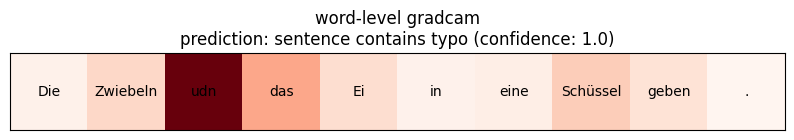

In [154]:
display("Die Zwiebeln udn das Ei in eine Schüssel geben.")